<a href="https://colab.research.google.com/github/j2810/Branch-Predictor/blob/main/Colab_section_5_missing_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Values

In this section, we'll be learning different missing value imputation techniques by analyzing simulated customer lifetime value data. Customer Lifetime Value is the total monetary worth the customer has to the business, over the course of its business-customer relationship. In this dataset, to keep things simple, we'll be using purchases as a proxy for CLV.

We'll be covering how to:

- Check the number of null values

- Dropping Null Values

- Mean/Median/Mode Imputation

- Multiple Imputation using Regression

- Imputation using Nearest Neighbors

Let's get started!

This a companion notebook for the **365 Data Science Course "Machine Learning Process A-Z"**. In the course, there is a video walkthrough of this notebook as well as theory and definitions of each of the techinques. We've designed this notebook to be a stand alone learning tool, but if you're interested in the additional features of the paid course, you can access it at a discount here: https://365datascience.com/courses/learn-machine-learning-process-a-z/

## Import Libraries

First, we'll need to import the relevant libraries. We'll be using the standard `pandas`, `numpy` libraries for data manipulation. We'll then be using `sklearn` for the more advanced imputation techniques. We will use `scipy` for the `mode` imputation later on:

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

## Load Data

Next, we'll load our customer lifetime value dataset. You'll see in our dataset, we have about 6 columns. The `purchases` column is the column we care about in our customer lifetime value problem.

Click this link and add select "Add a shortcut to Drive": https://drive.google.com/drive/folders/1-72dHg8M92bgwrl8WsruuBbUr9GmRr-W?usp=sharing

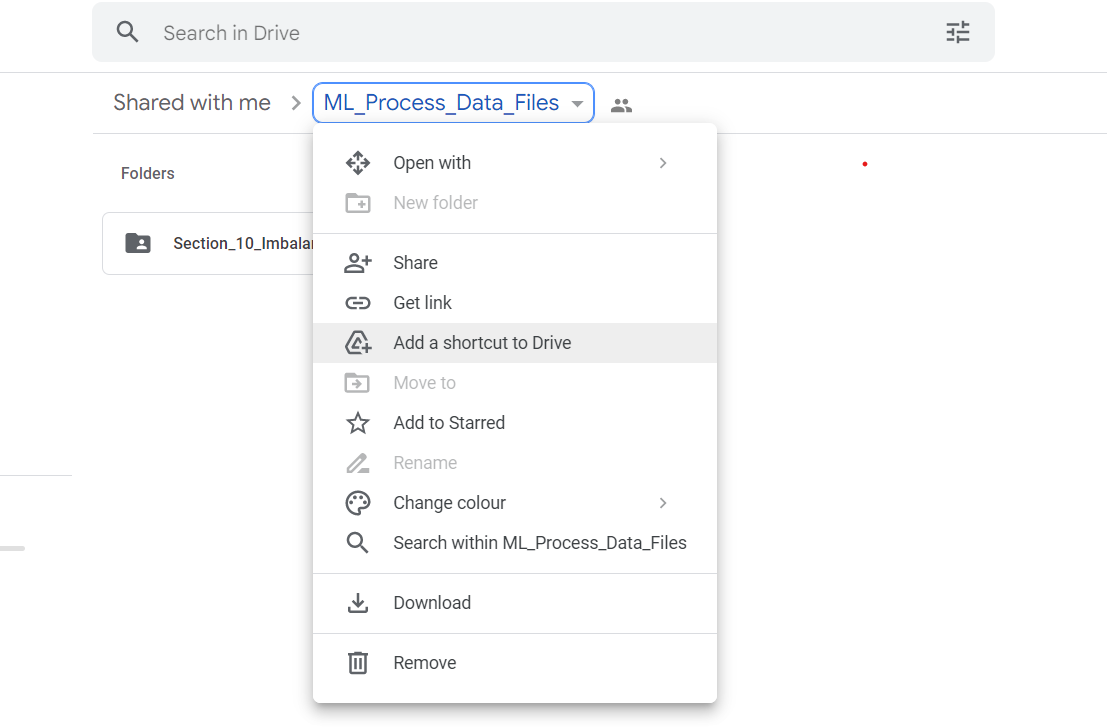

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/'My Drive'/ML_Process_Data_Files/Section_5_Data_Preprocessing

clv_data.csv


In [ ]:
import random

df = pd.read_csv("drive/My Drive/ML_Process_Data_Files/Section_5_Data_Preprocessing/clv_data.csv")

df['lifetime_value'] = df['purchases'] * 20

df.head()

,Unnamed: 0,id,age,gender,income,days_on_platform,city,purchases,lifetime_value
0,0,0,NaN,Male,126895,14.0,San Francisco,0,0
1,1,1,NaN,Male,161474,14.0,Tokyo,0,0
2,2,2,24.0,Male,104723,34.0,London,1,20
3,3,3,29.0,Male,43791,28.0,London,2,40
4,4,4,18.0,Female,132181,26.0,London,2,40


In [ ]:
random.randint(5,50)

## Checking Null Values

The first step in any data analysis or ML model is to check null values. We can check the number of nulls in a single line:

In [ ]:
df.isnull().sum()

However, if you want to see the percentages, we wrote a function you can use:

In [ ]:
def nulls_summary_table(df):
    """
    Returns a summary table showing null value counts and percentage

    Parameters:
    df (DataFrame): Dataframe to check

    Returns:
    null_values (DataFrame)
    """
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count','null_pct']
    return null_values

nulls_summary_table(df)

### Dropping Null Values

Dropping nulls is the quickest and easiest method to dropping nulls. We will use the internal pandas method `dropna` which will simply drop all rows that contain nulls:

In [ ]:
drop_df = df.copy()

drop_df = drop_df.dropna()

In [ ]:
X_d = drop_df[['age','days_on_platform','income']]
y_d = drop_df['lifetime_value']


X_train_d = X_d[:4000]
y_train_d = y_d[:4000]

X_test_d = X_d[1000:]
y_test_d = y_d[1000:]

### Mean/Median/Mode Imputation

The next is mean/median/mode imputation. We can use the native numpy functions for the mean and median. We can use scipy for the mode. Then, pandas as a native `fillna` method we can use to impute the nulls with the mean/median/mode:

In [ ]:
m_df = df.copy()

X_m = m_df[['age','days_on_platform','income']]
y_m = m_df['lifetime_value']


X_train_m = X_m[:4000]
y_train_m = y_m[:4000]

X_test_m = X_m[1000:]
y_test_m = y_m[1000:]

In [ ]:
## Mean
X_train_m.loc[:,'age'] = X_train_m['age'].fillna(np.mean(X_train_m['age']))
X_test_m.loc[:,'age'] = X_test_m['age'].fillna(np.mean(X_train_m['age'])) ## Cannot use training dataset to impute


X_train_m.loc[:,'days_on_platform'] = X_train_m['days_on_platform'].fillna(np.mean(X_train_m['days_on_platform']))
X_test_m.loc[:,'days_on_platform'] = X_test_m['days_on_platform'].fillna(np.mean(X_train_m['days_on_platform'])) ## Cannot use training dataset to impute

In [ ]:
## Median
m_df.loc[:,'age'] = df['age'].fillna(np.median(m_df['age']))

In [ ]:
## Mode
m_df.loc[:,'age'] = m_df['age'].fillna(stats.mode(m_df['age'])[0][0])

### Multiple Imputation Using Regression

Now that we've covered the simpler imputation techniques, we'll cover a more complicated imputation technique: Multiple Imputation. Multiple Imputation requires you to have some knowledge of ML modeling because we are using an ML model to impute the missing values. We won't go over every argument, but we'll go over the key ones.

Multiple imputation has a few different estimators, using the `estimator` argument:

- `BayesianRidge`: Regularized Linear Regression

- `RandomForestRegressor`: Random Forest Model. Mimics missForest in the R language.

We'll go over how these estimators work in the next course: ML Algorithms.

The `missing_values` argument is a placeholder for the data type of the missing values you want to impute.

It's important to use `add_indicatorbool` as it'll create a placeholder indicating that you've imputed a missing value. This is important, because there could be patterns behind how a value is missing. Adding an indicator would allow you to keep track of where you made an imputation. Plus, it could also add signal into your model.

`max_iter`: The number of iteration rounds.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

## Target - Purchases in the first six months

r_df = df.copy()

X_r = r_df[['age','days_on_platform','income']]
y_r = r_df['lifetime_value']


X_train_r = X_r[:4000]
y_train_r = y_r[:4000]

X_test_r = X_r[1000:]
y_test_r = y_r[1000:]


Imp = IterativeImputer(max_iter=10, random_state = 0)
Imp.fit(X_train_r)

X_train_r = Imp.transform(X_train_r)
X_test_r = Imp.transform(X_test_r)

X_train_r = pd.DataFrame(X_train_r)
X_train_r.columns = X_train_r.columns

X_test_r = pd.DataFrame(X_test_r)
X_test_r.columns = X_test_r.columns

r_df = pd.concat([X_train_r,X_test_r],axis = 0)

### Nearest Neighbor Imputation

On top of using linear regression or random forest regression to impute values, you can also use nearest neighbors imputation. Nearest neighbor imputation essentially uses a K-Nearest Neighbors algorithm to find the most similar data points, to impute the null values.

**Important Parameters**

`missing_values`: This is the type of null value you want to impute. Typically, this is NaN, but it could be float or whichever you decide.

`n_neighbors`: The number of neighbors to use for imputation. You can add more or less. Fewer neighbors can lead to overfitting. Larger numbers will lose some precision.

`weights`: Pick how you want to weight all points in each neighborhood. There are two typical ways: `'uniform'` or `'distance'`. Uniform is equal weighting. Distance is weighted by the distance from the point.

- `callable` : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

`metric`: The distance metric used to search for neighbors. The default is euclidean.

`add_indicator`: This will add a dummy feature 0 or 1 if the value was imputed, similar to `add_indicatorbool`.

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputer.fit(X_train_r)
X_train_k = imputer.transform(X_train_r)
X_test_k = imputer.transform(X_test_r)

y_train_k = y_train_r.copy()
y_test_k = y_test_r.copy()

## Comparison

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Drop Null Model
clf_n = RandomForestRegressor(random_state=0)
clf_n.fit(X_train_d, y_train_d)
pred_dropna = clf_n.predict(X_test_d)

# Mean Imputation Model
clf_m = RandomForestRegressor(random_state=0)
clf_m.fit(X_train_m, y_train_m)
pred_m = clf_m.predict(X_test_m)

# Regression Imputation
clf_r = RandomForestRegressor(random_state=0)
clf_r.fit(X_train_r, y_train_r)
pred_r = clf_r.predict(X_test_r)

#Nearest Neighbor Imputation
clf_n = RandomForestRegressor(random_state=0)
clf_n.fit(X_train_k, y_train_k)
pred_k = clf_n.predict(X_test_k)


print('Drop Null MAE Score: %.3f' % mean_absolute_error(y_test_d,pred_dropna))
print('Mean Impute MAE Score: %.3f' % mean_absolute_error(y_test_m,pred_m))
print('Regression MAE Score: %.3f '% mean_absolute_error(y_test_r,pred_r))
print('Nearest Neighbor MAE Score: %.3f'% mean_absolute_error(y_test_k,pred_k))

## Summary

In this section, you learned about a variety of missing value imputation techniques, ranging from simple to more complex. We went over:

- Dropping Nulls

- Mean/Median/Mode Imputation

- Regression Imputation (linear and forests)

- Nearest Neighbor Imputation

## Additional Resources
- [All You Need To Know About Different Types Of Missing Data Values And How To Handle It](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/#:~:text=Types%20Of%20Missing%20Values,Missing%20Not%20At%20Random%20(MNAR))
- [7 Ways to Handle Missing Values in Machine Learning](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)
- [Null Values Imputation by Utkarsh Gupta](https://www.kaggle.com/general/248836)
- [What are methods to make a predictive model more robust to outliers?](https://www.quora.com/What-are-methods-to-make-a-predictive-model-more-robust-to-outliers)
- [Guidelines for Removing and Handling Outliers in Data by Jim Frost](https://statisticsbyjim.com/basics/remove-outliers)

## Related Course Workbooks - Machine Learning Process A-Z
- [**Dealing with Missing Values - Section 5.1**](https://colab.research.google.com/drive/1P-4i_T1UE8_PLZibNApGbGPDxhOJDnd8?usp=sharing)
- [**Dealing with Outliers - Section 5.2**](https://colab.research.google.com/drive/1e_9VUn48sOebsEmDMRZ2R7OEkJLM9Zxt?usp=sharing)
- [**Basic EDA Example - Section 6**](https://colab.research.google.com/drive/18sWPkf2o6yX2RJu0YRZRCbJqNzc5q8ZS?usp=sharing)
- [**Categorical Feature Engineering - Section 7.1**](https://colab.research.google.com/drive/1F94kWYM_GTb-Neh_jCte04BxfcUdBodn?usp=sharing)
- [**Numeric Feature Engineering - Section 7.2**](https://colab.research.google.com/drive/1SGwguOuloOG7nd3OoOGBALR9jOg26UNt?usp=sharing)
- [**Cross Validation Foundations - Section 8**](https://colab.research.google.com/drive/1xsVT5MWAX1Yq8KXMPbqU6DBti-NN17YH?usp=sharing)
- [**Feature Selection - Section 9**](https://colab.research.google.com/drive/19uXC7Cm_K1FDTjkcRVjxcAY4f7dv6LDV?usp=sharing)
- [**Dealing with Imbalanced Data - Section 10**](https://colab.research.google.com/drive/1pulqugw0V1xyoMbQrB3aTdlwO0KDXDFf?usp=sharing)
- [**Model Building Example - Section 11**](https://colab.research.google.com/drive/1oV675pKGmCLIYE44a_Quw1s66c4LVcOq?usp=sharing)
- [**Model Evaluation (Classification) - Section 12**](https://colab.research.google.com/drive/1FYHAL3lbv7Rdh3EV9TooMFkPNv6MEJly?usp=sharing)
- [**Model Evlauation (Regression) - Section 12**](https://colab.research.google.com/drive/1_of9a48P-rGkrS8US9YgwQm_58_1unAV?usp=sharing)